In [1]:
import re
import os
import itertools
import networkx as nx
import time
from IPython.display import clear_output
import numpy as np
import csv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from networkx.algorithms import bipartite

In [2]:
pokemon_dir = "./pokemon_gen1/"
pokemon_names = sorted(os.listdir("pokemon_gen1/"))
pokemon_names.remove("[151]Mew")

In [3]:
all_occurances = {}
location_list = set()
raw_locations = {}

for pokemon in pokemon_names:
    poke_path = pokemon_dir + pokemon
    poke_file = open(poke_path, encoding='utf-8').read()
    pokemon_text = re.findall(r"(?<=Game locations===)(.*)(?=In side games)", poke_file)
    poke_VandA = re.findall(r"(v=)(.*?)\\\\n", str(pokemon_text))
    for x in poke_VandA :
        if pokemon not in raw_locations:
            raw_locations[pokemon] = [x[1]]
        else:
            raw_locations[pokemon].append(x[1])

In [4]:
for pokemon, version in raw_locations.items():
    places = set()
    for x in version:
        v1 = re.findall(r".+?(?=\|)", str(x))
        if len(v1) > 0:
            v1 = v1[0]
        else:
            v1 = re.findall(r".+?(?=\})", str(x))
            v1 = v1[0]
        if v1 == "Yellow":
            x = x.replace("[", "{")
            x = x.replace("]", "}")
            loc = re.findall(r"(?<=\{\{)(.*?)(?=\}\})", str(x))
            for place in loc:
                if "List" in place:
                    place = "Special Event"
                elif place[:2] == 'p|':
                    continue
                elif "Surf" in place or "surf" in place:
                    place = "Surfing"
                if place[:3] == 'rtn':
                    place = place.replace('rtn', 'rt', 1)
                places.add(place)
                location_list.add(place)
    if places == set():
        pokemon_names.remove(pokemon)
    if ('Evolution|Evolve') in places:
        pokemon_names.remove(pokemon)
        continue
    if "Route" in places:
        places.remove("Route")
    if "Routes" in places:
        places.remove("Routes")
    all_occurances[pokemon] = places

In [5]:
location_list.remove("Routes")
location_list.remove("Route")
location_list.remove('Evolution|Evolve')

In [6]:
G = nx.Graph()
G.add_nodes_from(pokemon_names)
G.add_nodes_from(location_list)

In [7]:
for name, locations in all_occurances.items():
    for place in locations:
        G.add_edge(name, place)

In [8]:
names, locations = bipartite.sets(G)

# sub_graphs = nx.connected_component_subgraphs(G)

# for i, sg in enumerate(sub_graphs):
#     print(f"subgraph {i} has {sg.number_of_nodes()} nodes")
#     print ("\tNodes:", sg.nodes(data=True))
#     print ("\tEdges:", sg.edges())

In [38]:
nodes = list(G.nodes())

for node in range(len(nodes)):
    if (re.search(r"rt\|(\d*?)\|Kanto", nodes[node])):
        number = re.findall(r"rt\|(\d*?)\|Kanto", nodes[node])[0]
        nodes[node] = nodes[node].replace(nodes[node], f"Kanto Route {number}")
    elif (nodes[node] == 'Evolution|Evolve'):
        nodes[node] = "Evolution"
    elif (nodes[node] == 'In-game trade#Yellow|Trade'):
        nodes[node] = "Trade for"
    elif ("List" in nodes[node]):
        nodes[node] = "Special Event"
    elif (nodes[node] == 'Fishing#In the games|Super Rod'):
        nodes[node] = "Fishing"
    elif (nodes[node] == 'tt|*|immediately evolves into Machamp, but Pokédex data is entered'):
        nodes[node] = "Immediately evolves"
    elif (nodes[node] == "Diglett\\\\'s Cave"):
        nodes[node] = "Deglett's Cave"
    elif ("|" in nodes[node]):
        nodes[node] = nodes[node].replace("|", " ")       

In [39]:
node_adjacencies = []
color_map = []
for x in G.nodes():
    if x in location_list:
        color_map.append('rgb(0,240,0)')
    else:
        color_map.append('rgb(192, 143, 227)')
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(5 + len(adjacencies[1]))

In [27]:
pos=force_atlas2.forceatlas2_networkx_layout(G, pos=None, iterations=1000)
Xn=[pos[k][0] for k in G.nodes()]
Yn=[pos[k][1] for k in G.nodes()]

trace_nodes=dict(type='scatter',
                 x=Xn, 
                 y=Yn,
                 mode='markers',
                 text=nodes,
                 marker=dict(size=node_adjacencies, color=color_map),
                 hoverinfo='text')

Xe=[]
Ye=[]
for e in G.edges():
    Xe.extend([pos[e[0]][0], pos[e[1]][0], None])
    Ye.extend([pos[e[0]][1], pos[e[1]][1], None])
trace_edges=dict(type='scatter',
                 mode='lines',
                 x=Xe,
                 y=Ye,
                 line=dict(width=1, color='rgb(25,25,25)'),
                 hoverinfo='none' 
                )

100%|██████████| 1000/1000 [00:00<00:00, 1521.44it/s]

BarnesHut Approximation  took  0.23  seconds
Repulsion forces  took  0.34  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


In [30]:
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )
layout=dict(width=600,
            height=600,
            autosize=False,
            showlegend=False,
            xaxis=axis,
            yaxis=axis,
            margin=dict(
            l=40,
            r=40,
            b=85,
            t=100,
            pad=0,
       
    ),
    hovermode='closest',
    plot_bgcolor='#efecea', #set background color            
    )


fig = dict(data=[trace_edges, trace_nodes], layout=layout)

In [31]:
from plotly.offline import iplot

iplot(fig)

In [14]:
from community import best_partition, modularity
from fa2 import ForceAtlas2
from matplotlib import cml

In [15]:
coms = best_partition(nx.Graph(G))
com_ids = np.array(list(coms.values()))
print('The modularity of the network:', round(modularity(coms, nx.Graph(G)), 5))

The modularity of the network: 0.53327


In [16]:
for color in range(len(color_map)):
    color_map[color] = color_map[color][4:-1].split(",")
    color_map[color][0] = int(color_map[color][0]) / 255
    color_map[color][1] = int(color_map[color][1]) / 255
    color_map[color][2] = int(color_map[color][2]) / 255
    color_map[color] = tuple(color_map[color])

100%|██████████| 400/400 [00:00<00:00, 1369.75it/s]


BarnesHut Approximation  took  0.12  seconds
Repulsion forces  took  0.13  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



(-209.49915899927777,
 184.55902355578863,
 -147.15133432405912,
 183.6583539540564)

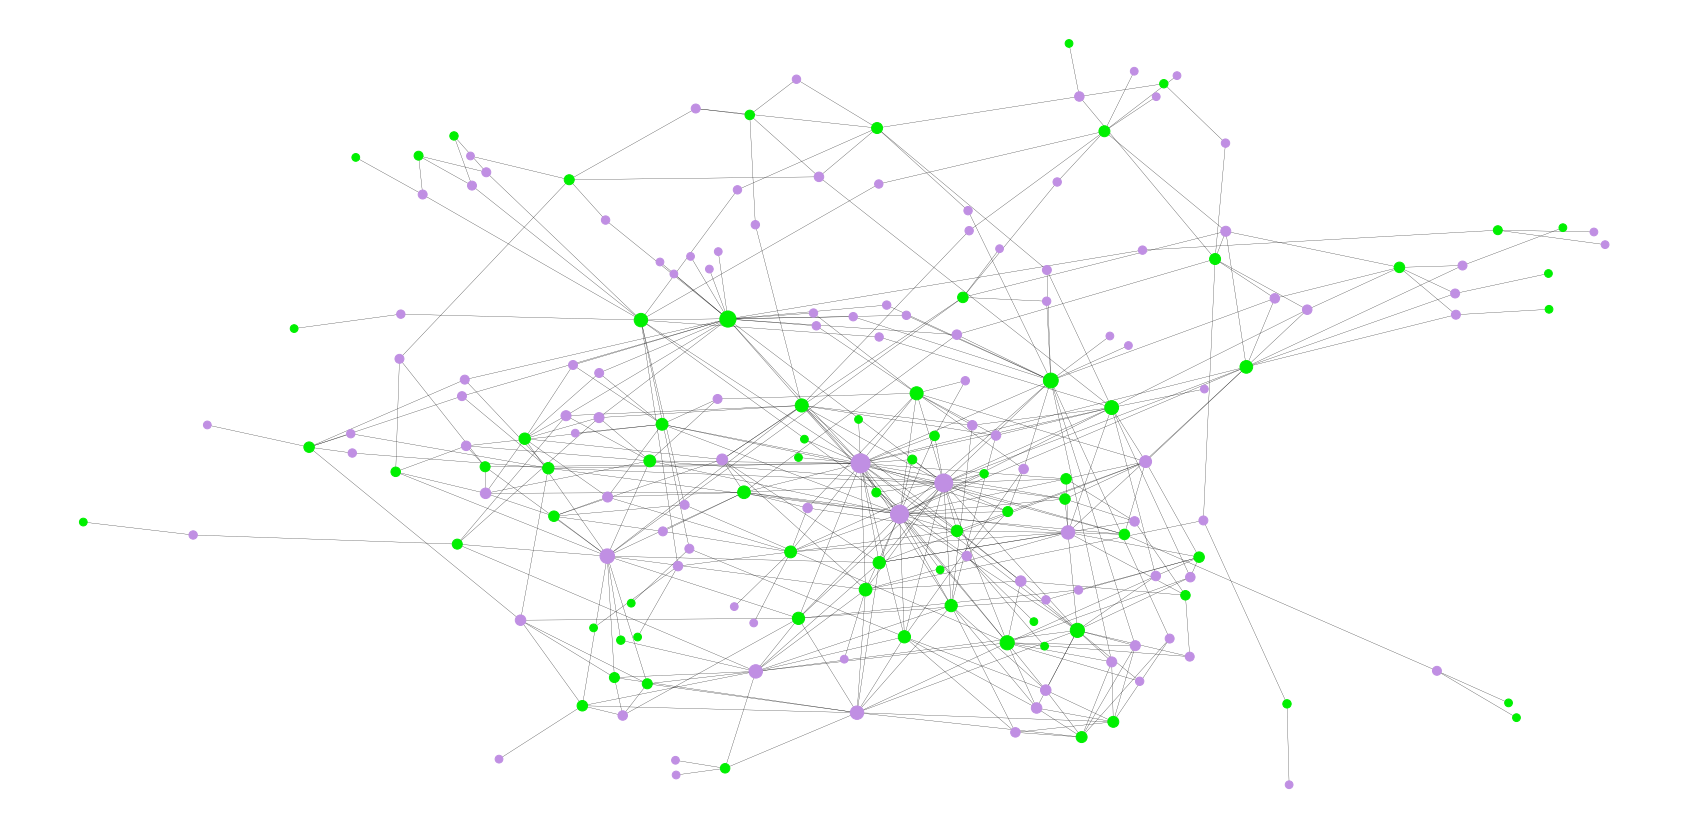

In [17]:
newG = nx.Graph(G)
force_atlas2 = ForceAtlas2()
positions = force_atlas2.forceatlas2_networkx_layout(newG, pos=None, iterations=400)

plt.figure(figsize=(30,15))
nx.draw_networkx_nodes(newG, pos=positions, node_color = color_map, 
                       node_size = [10*v for v in node_adjacencies])

nx.draw_networkx_edges(newG, pos=positions, width = 0.25 )

plt.axis('off')